In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import os

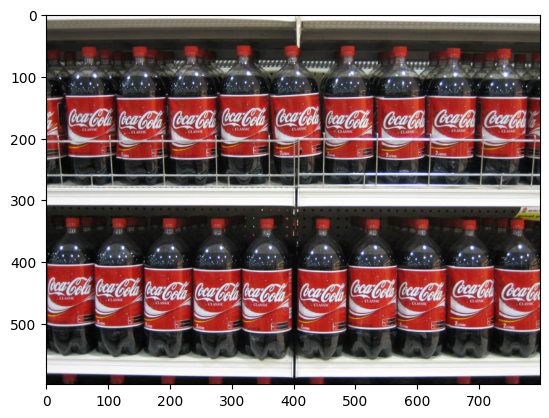

In [2]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)

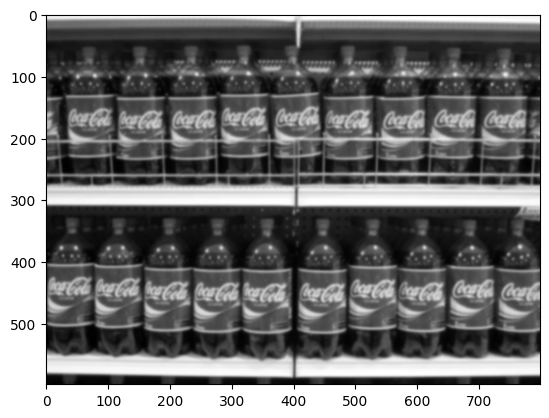

In [99]:
def filter_closed_loops(gray):
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        if cv.arcLength(contour, True) > 100:
            cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)
    filtered_image = cv.bitwise_and(binary, mask)
    return filtered_image
    
def preprocess(image):
    # recommendeded ratios for canny are: 2:1 and 3:1,
    value = 115
    ratio = 2 
    threshold_1, threshold_2 = value, value*ratio
    # if len(image.shape) == 3:
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    # grayscale = cv.equalizeHist(grayscale)
    blurred = cv.GaussianBlur(grayscale, (9, 9), 0)
    # sharpened = um(blurred)
    canny_edges = cv.Canny(sharpened, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred,threshold_1, threshold_2)
    # filtered = filter_closed_loops(canny_edges_after_blur)
    # return grayscale, blurred, sharpened, canny_edges, canny_edges_after_blur, filtered
    return grayscale, blurred, canny_edges, canny_edges_after_blur

# from skimage.filters import unsharp_mask
# def um(img):
#     um_img = unsharp_mask(img, radius=10, amount=0.5)
#     sharpened = cv.normalize(um_img, None, 0, 255,cv.NORM_MINMAX, dtype=cv.CV_8U)
#     return sharpened

def preprocess_(image):
    return preprocess(image)[3]

# grayscale, blurred, sharpened, canny_edges, canny_edges_after_blur, filtered = preprocess(coca_multi)
grayscale, blurred, canny_edges, canny_edges_after_blur = preprocess(coca_multi)
plt.imshow(blurred, cmap='gray')

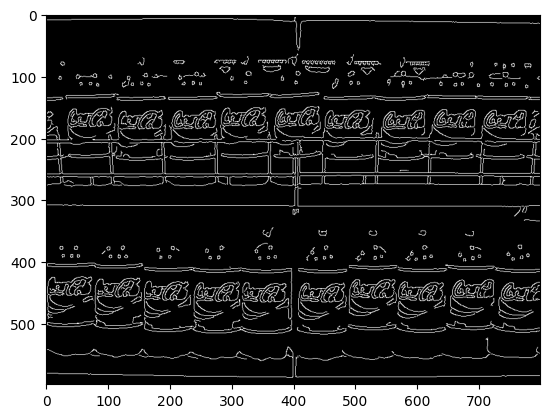

In [90]:
plt.imshow(canny_edges, cmap='gray')

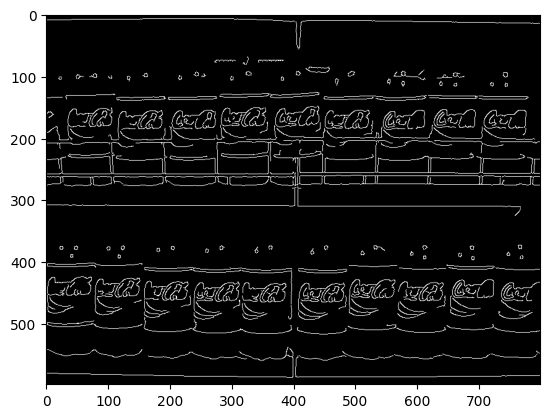

In [91]:
plt.imshow(canny_edges_after_blur, cmap='gray')

3.125

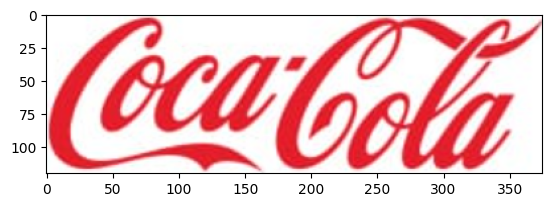

In [93]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template_reduced = template[30:-25, 10:-15]
plt.imshow(template_reduced)
aspect_ratio = template_reduced.shape[1]/template_reduced.shape[0]
aspect_ratio

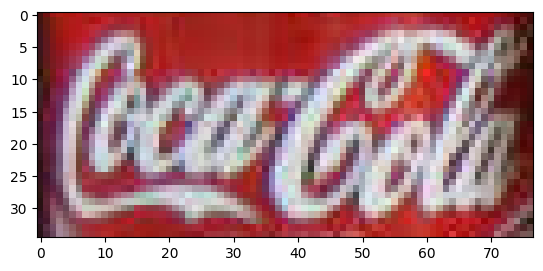

In [95]:
some_other = coca_multi.copy()
some_other = some_other[150:185,33:110,:]
plt.imshow(some_other)

In [96]:
some_other.shape

(35, 77, 3)

In [97]:
aspect_ratio = some_other.shape[1]/some_other.shape[0]
aspect_ratio

2.2

In [124]:
import imutils
def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    template_reduced = template[30:-25, 10:-15]
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = gray.shape[::-1]
    scales = np.linspace(0.5,2.0,10) 
    found = {}    
    min_result = 1e20
    max_result = -1e20
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    
    for scale in np.linspace(0.2,2,40):
        resized = imutils.resize(template_reduced, width=int(template_reduced.shape[1] * scale))
        for scale_w in np.linspace(0.5,1.0,6):
            h,w,_ = resized.shape
            new_resized = cv.resize(resized, (int(w*scale_w),h))
            if new_resized.shape[0] <= 0.05 * image_rgb.shape[0] or new_resized.shape[1] <= 0.05*image_rgb.shape[1]:
                continue
            try:
                result = cv.matchTemplate(edged, preprocess_(new_resized), method)
                found[f'{new_resized.shape[0]},{new_resized.shape[1]}'] = result
                all_results = np.concatenate((all_results, result.flatten()))
                min_result = min(min_result, np.min(result))
                max_result = max(max_result, np.max(result))
            except Exception as e:
                pass

    # print(max_result)
    # print(min_result)
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
        # if len(loc[0]) > 0:
            # print('found loc:', loc)
        h, w =[int(el) for el in scale_hash.split(',')]

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = top_left[0], top_left[1]
            endX, endY = top_left[0]+w, top_left[1]+h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)

    return normalize(all_results, max_result, min_result), modified_image

hist_data, modified_image = detect_logo(coca_multi, cv.TM_CCORR_NORMED, threshold=0.80)


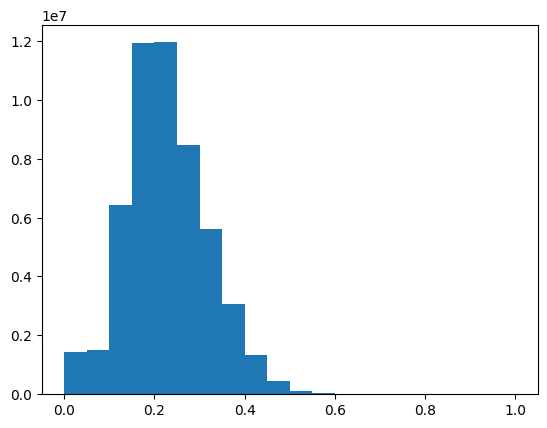

In [125]:
_ = plt.hist(hist_data, bins=20)

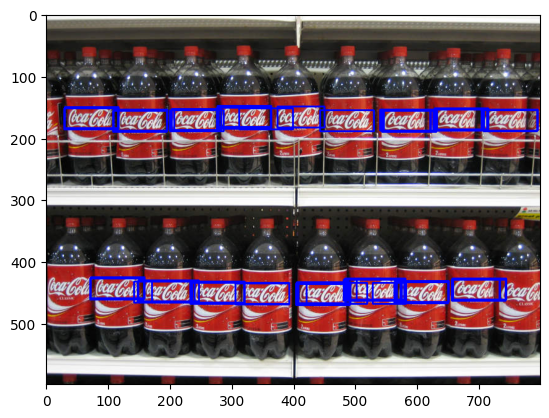

In [126]:
plt.imshow(modified_image)

In [ ]:
new_img2 = modified_image.copy()
resized_im = imutils.resize(template_reduced, width=int(template_reduced.shape[1]*0.3))
h,w,_ = resized_im.shape
resized_im2 = cv.resize(resized_im, (int(w*0.7),h))
# new_img2[90:90+resized_im.shape[0], 20:20+resized_im.shape[1],:] = resized_im
new_img2[150:150+resized_im2.shape[0], 35:35+resized_im2.shape[1],:] = resized_im2

plt.imshow(new_img2)

In [9]:
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

In [ ]:
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

def plot_images(img_list, cols=3):
    rows = len(img_list)//cols + 1
    f, axes = plt.subplots(rows,cols, figsize=(20,15)) 
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        if i < len(img_list):
            ax.imshow(img_list[i])
        else:
            ax.axis('off')

detections = []
for image in test_images_color:
    _, modified_img = detect_logo(image, cv.TM_CCORR_NORMED, threshold=0.9)
    detections.append(modified_img)
plot_images(detections)

In [ ]:
def detect_logo_with_nms(image_rgb, method):
    pre_template = preprocess_(template[30:-25, 10:-15])
    tW, tH = pre_template.shape[::-1]
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    scales = np.linspace(0.2, 2.0, 20)

    bounding_boxes = []
    confidences = []

    for scale in scales[::-1]:
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        if tH > resized.shape[0] or tW > resized.shape[1]:
            break

        edged = preprocess_(resized)
        result = cv.matchTemplate(edged, pre_template, method)
        normalized_result = cv.normalize(result, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

        threshold = 0.80
        loc = np.where(normalized_result >= threshold)
        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = int(top_left[0] * r), int(top_left[1] * r)
            endX, endY = int((top_left[0] + tW) * r), int((top_left[1] + tH) * r)
            bounding_boxes.append([startX, startY, endX - startX, endY - startY])
            confidences.append(float(normalized_result[pt[1], pt[0]]))


    bounding_boxes = np.array(bounding_boxes)
    confidences = np.array(confidences)

    indices = cv.dnn.NMSBoxes(bounding_boxes.tolist(), confidences.tolist(), score_threshold=0.8, nms_threshold=0.2)
    
    if len(indices) > 0:
        for i in indices.flatten():
            startX, startY, w, h = bounding_boxes[i]
            endX, endY = startX + w, startY + h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)

    return modified_image



detections = [detect_logo_with_nms(image, cv.TM_CCOEFF) for image in test_images_color]
plot_images(detections)

In [ ]:
def detect_logo_with_grouping(image_rgb, method):
    pre_template = preprocess_(template[30:-25, 10:-15])
    tW, tH = pre_template.shape[::-1]
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    scales = np.linspace(0.2, 2.0, 20)
    

    rectangles = []

    for scale in scales[::-1]:
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        if tH > resized.shape[0] or tW > resized.shape[1]:
            break

        edged = preprocess_(resized)
        result = cv.matchTemplate(edged, pre_template, method)
        normalized_result = cv.normalize(result, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

        threshold = 0.8
        loc = np.where(normalized_result >= threshold)

        for pt in zip(*loc[::-1]):
            startX, startY = int(pt[0] * r), int(pt[1] * r)
            endX, endY = int((pt[0] + tW) * r), int((pt[1] + tH) * r)
            rectangles.append([startX, startY, endX - startX, endY - startY])  # [x, y, w, h]

    grouped_rectangles, _ = cv.groupRectangles(rectangles, groupThreshold=3, eps=0.2)

    for (x, y, w, h) in grouped_rectangles:
        cv.rectangle(modified_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    return modified_image


detections = [detect_logo_with_grouping(image, cv.TM_CCOEFF) for image in test_images_color]
plot_images(detections)

In [ ]:
import cv2
import numpy as np

# Load the object image and the scene image
# template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template = cv.bitwise_not(cv.imread('template/pattern.png')) #[10:-10,180:-120,:]

# coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
img = cv.imread('images/coca_multi.png')

# Convert both images to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(template_gray, None)
kp2, des2 = sift.detectAndCompute(img_gray, None)

# Initialize the Brute-Force matcher and match descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the matches
img_matches = cv2.drawMatches(template_gray, kp1, img_gray, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))  # Adjust width (20) and height (10) for full width
plt.imshow(img_matches)
plt.axis('off')  # Hide axis for better visualization
plt.show()

In [ ]:
kp2[0].pt

In [ ]:
points_to_visit = [curr_kp.pt for curr_kp in kp2]
# print(points_to_visit)

In [ ]:
info = []
img_w_bboxes = img.copy()
edged_template = preprocess(template_gray)[3]
edged_img = preprocess(img_gray)[3]
for z,point in enumerate(points_to_visit):
    # print(f'iterating: {100*z/(len(points_to_visit))}')
    scales = np.linspace(0.2, 2.0, 6)
    for scale in scales[::-1]:
        resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
        h,w = resized.shape
        start_h = int(point[1]-h//2)
        end_h = start_h + h
        start_w = int(point[0]-w//2)
        end_w = start_w + w 
        # print(point)
        if start_h >= 0 and start_w >= 0 and end_h < edged_img.shape[0] and end_w < edged_img.shape[1]:
            result = cv2.matchTemplate(resized, edged_img, cv.TM_CCORR_NORMED)
            area = h*w
            max_val = np.max(result) + 1/area
            info.append([max_val, (start_w,start_h), (end_w,end_h)])

    

In [ ]:
hist_data = sorted([el for el, sp, ep in info])
plt.hist(hist_data)


In [ ]:
img_w_bboxes = img.copy()
bboxes = [(sp,ep) for el,sp,ep in info if el > 0.30]
for sp,ep in bboxes:
    cv.rectangle(img_w_bboxes, sp, ep, (0, 0, 255), 2)

plt.imshow(img_w_bboxes)

In [ ]:
plt.imshow(template_gray)

In [ ]:
img_with_keypoints = cv2.drawKeypoints(img, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_with_keypoints)

In [ ]:
img_with_keypoints = cv2.drawKeypoints(img, [kp for kp in kp2 if kp.size > 10], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_with_keypoints)

In [ ]:
import cv2
import numpy as np

# Load the object image and the scene image
# template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template = cv.bitwise_not(cv.imread('template/pattern.png'))

# coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
img = cv.imread('images/coca_multi.png')

# Convert both images to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

orb = cv.ORB_create()

# Detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(template_gray, None)
kp2, des2 = orb.detectAndCompute(img_gray, None)

# Initialize the Brute-Force matcher and match descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the matches
img_matches = cv2.drawMatches(template_gray, kp1, img_gray, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))  # Adjust width (20) and height (10) for full width
plt.imshow(img_matches)
plt.axis('off')  # Hide axis for better visualization
plt.show()